In [1]:
%load_ext autoreload
%autoreload 2

from codes.Kalman import *
from scipy.integrate import odeint
from sklearn.linear_model import LinearRegression
import random

%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

Populating the interactive namespace from numpy and matplotlib


/home/administrateur/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Important parameters

In [2]:
# index of the unobserved component
i_unobs_comp = 0

# integration time step
dt = 0.001

# variance of the random white noise of z
variance_unobs_comp = 5

# variance of the observation error used in Kalman
variance_obs_comp = 0.0001

# number of Lorenz-63 times
nb_loop = 10

# number of SEM iterations
nb_iter_SEM = 30

### Generate simulated data

In [3]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

# Lorenz-63 parameters
x0 = array([8, 0, 30]) # initial condition
sigma = 10; rho = 28; beta = 8/3 # physical parameters

# time and truth
t   = arange(0.01, nb_loop, dt)
x_t = odeint(Lorenz_63, x0, arange(0.01, nb_loop, dt), args=(sigma, rho, beta))

# observations
y = x_t.copy()
y = delete(y, i_unobs_comp, axis=1) # add noise here?

### V0: $x = [x_2, x_3]$

Text(0.5, 1.0, 'Observed components')

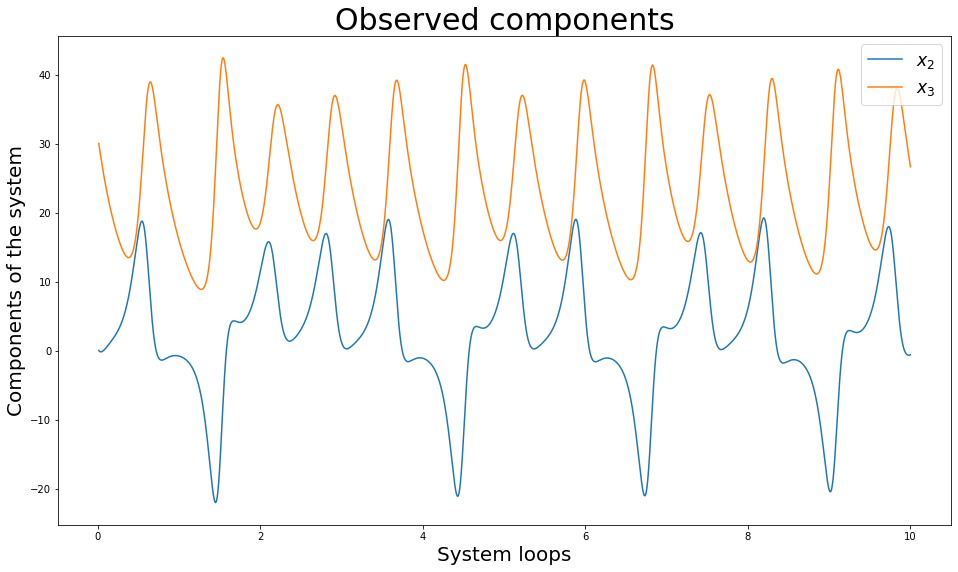

In [4]:
# state
x = c_[y[:,0], y[:,1]]

# shapes
n = shape(x)[1]
p = shape(y)[1]

# colors and labels of the components
tab_colors = ['C0', 'C1']
tab_labels = ['$x_2$', '$x_3$']

# plot the components
plot(t, x)
xlabel('System loops', size=20)
ylabel('Components of the system', size=20)
legend(tab_labels, loc=1, fontsize='xx-large')
title('Observed components', size=30)

In [5]:
# kalman parameters
H = eye(n)
R = variance_obs_comp*eye(p)

# stochastic EM
x_s_V0, P_s_V0, M_V0, loglik_V0, x, x_f_V0, Q_V0 = Kalman_SEM(x, y, H, R, nb_iter_SEM)

100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


### V1: $x = [x_2, x_3, z_1]$

In [6]:
# state
z = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])
x = c_[y[:,0], y[:,1], z]

# shapes
n = shape(x)[1]
p = shape(y)[1]

(0.01, 9.998999999999992)

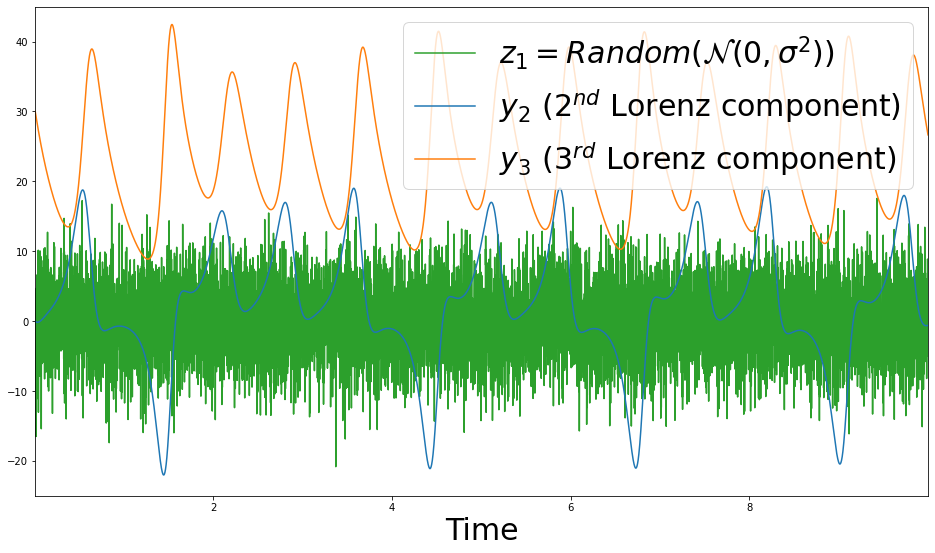

In [7]:
##################
### FIGURE 1-a ###
##################

tab_colors = ['C0', 'C1', 'C2']
tab_labels = ['$y_2 \ (2^{nd} \ \mathrm{Lorenz \ component})$', '$y_3 \ (3^{rd} \ \mathrm{Lorenz \ component})$', '$z_1 = Random(\mathcal{N}(0,\sigma^2))$']
for i in [2,0,1]:
    plot(t, x[:,i], color=tab_colors[i], label=tab_labels[i])
xlabel('Time', size=30)
legend(loc=1, prop={'size': 30})
ylim([-25,45])
xlim([t[0],t[-1]])

In [8]:
# kalman parameters
H = delete(eye(n), 2, axis=0)
R = variance_obs_comp*eye(p)

# stochastic EM
x_s_V1, P_s_V1, M_V1, loglik_V1, x, x_f_V1, Q_V1 = Kalman_SEM(x, y, H, R, nb_iter_SEM)

100%|██████████| 30/30 [00:54<00:00,  1.80s/it]


(0.01, 9.998999999999992)

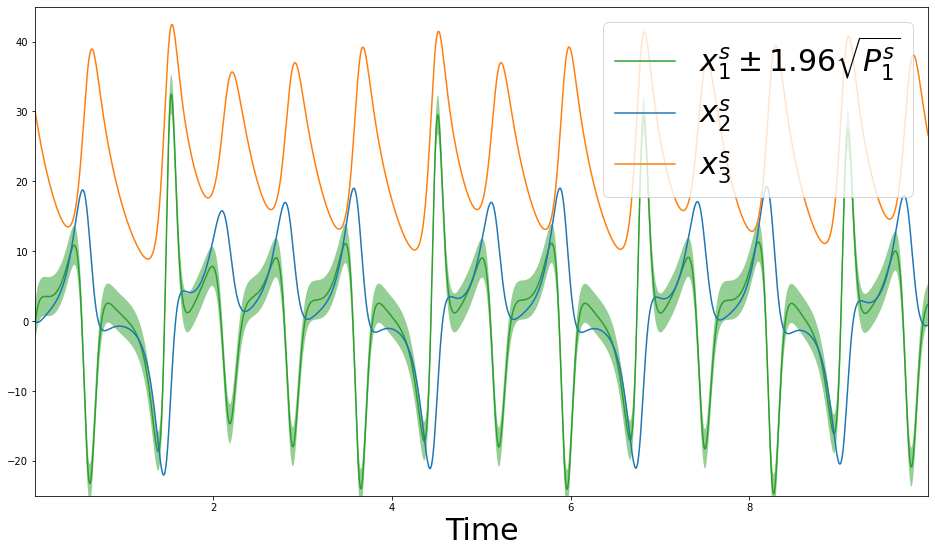

In [9]:
##################
### FIGURE 1-b ###
##################

tab_labels = ['$x^s_2$', '$x^s_3$', '$x^s_1 \pm 1.96 \sqrt{P^s_1}$']
for i in [2,0,1]:
    plot(t, x_s_V1[:,i], color=tab_colors[i], label=tab_labels[i])
    fill_between(t, x_s_V1[:,i]-1.96*sqrt(P_s_V1[:,i,i]), x_s_V1[:,i]+1.96*sqrt(P_s_V1[:,i,i]),
                 facecolor=tab_colors[i], alpha=0.50)   
xlabel('Time', size=30)
legend(loc=1, prop={'size': 30})
ylim([-25,45])
xlim([t[0],t[-1]])

### V2: $x = [x_2, x_3, z_1, z_2]$

Text(0.5, 1.0, 'Initial x')

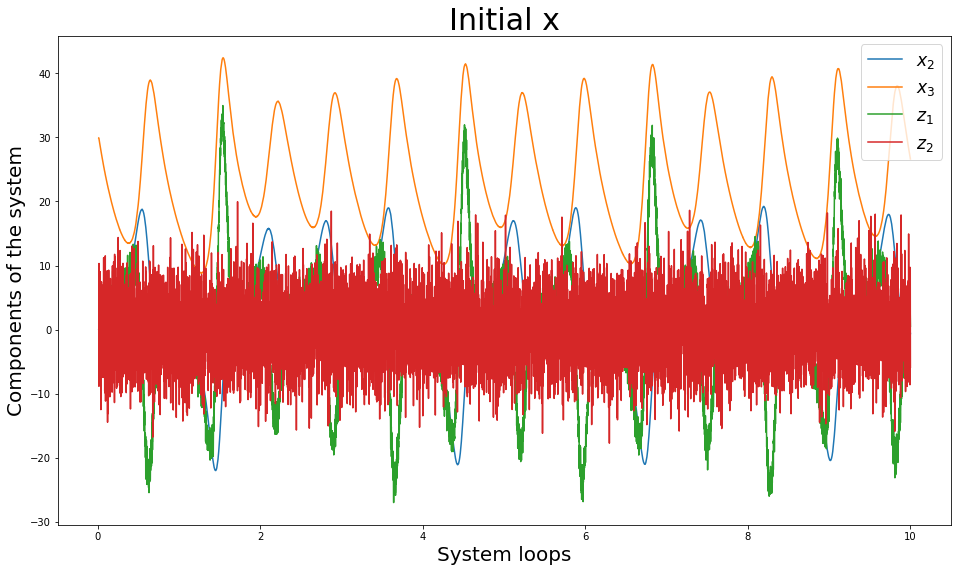

In [10]:
# state
z = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])
x = c_[x, z]

# shapes
n = shape(x)[1]
p = shape(y)[1]

# colors and labels of the components
tab_colors = ['C0', 'C1', 'C2', 'C3']
tab_labels = ['$x_2$', '$x_3$', '$z_1$', '$z_2$']

# plot the components
plot(t, x)
xlabel('System loops', size=20)
ylabel('Components of the system', size=20)
legend(tab_labels, loc=1, fontsize='xx-large')
title('Initial x', size=30)

In [11]:
# kalman parameters
H = delete(eye(n), [2,3], axis=0)
R = variance_obs_comp*eye(p)

# stochastic EM
x_s_V2, P_s_V2, M_V2, loglik_V2, x, x_f_V2, Q_V2 = Kalman_SEM(x, y, H, R, nb_iter_SEM)

100%|██████████| 30/30 [00:59<00:00,  1.97s/it]


Text(0.5, 1.0, 'Final x')

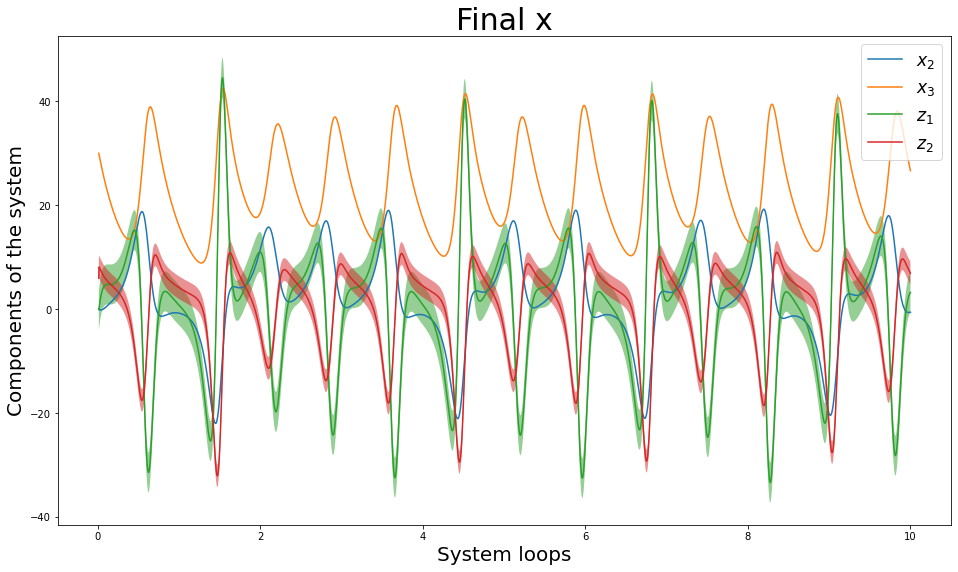

In [12]:
# plot the reconstructed components
for i in range(n):
    plot(t, x_s_V2[:,i], color=tab_colors[i])
    fill_between(t, x_s_V2[:,i]-1.96*sqrt(P_s_V2[:,i,i]), x_s_V2[:,i]+1.96*sqrt(P_s_V2[:,i,i]),
                 facecolor=tab_colors[i], alpha=0.50)

xlabel('System loops', size=20)
ylabel('Components of the system', size=20)
legend(tab_labels, loc=1, fontsize='xx-large')
title('Final x', size=30)

### V3: $x = [x_2, x_3, z_1, z_2, z_3]$

Text(0.5, 1.0, 'Initial x')

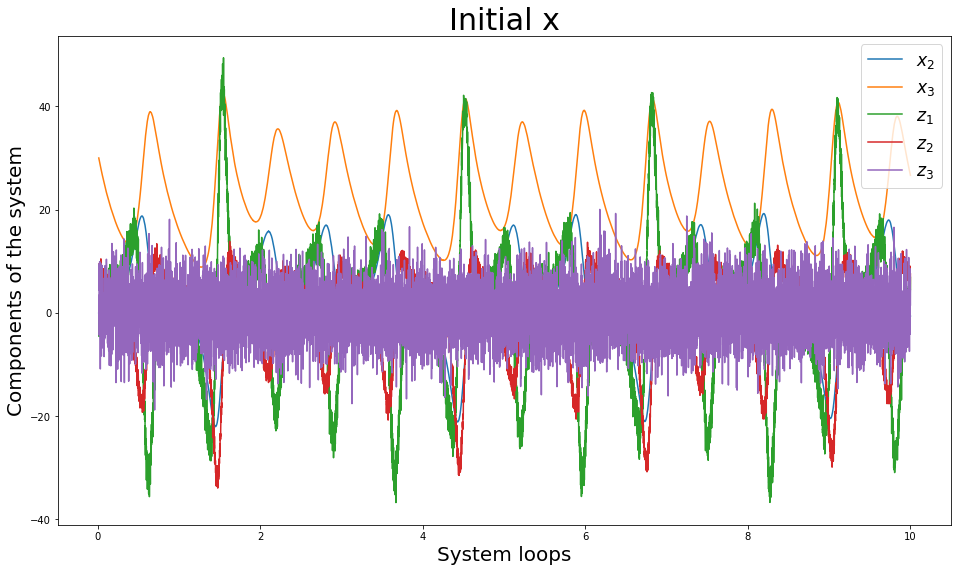

In [13]:
# state
z = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])
x = c_[x, z]

# shapes
n = shape(x)[1]
p = shape(y)[1]

# colors and labels of the components
tab_colors = ['C0', 'C1', 'C2', 'C3', 'C4']
tab_labels = ['$x_2$', '$x_3$', '$z_1$', '$z_2$', '$z_3$']

# plot the components
plot(t, x)
xlabel('System loops', size=20)
ylabel('Components of the system', size=20)
legend(tab_labels, loc=1, fontsize='xx-large')
title('Initial x', size=30)

In [14]:
# kalman parameters
H = delete(eye(n), [2,3,4], axis=0)
R = variance_obs_comp*eye(p)

# stochastic EM
x_s_V3, P_s_V3, M_V3, loglik_V3, x, x_f_V3, Q_V3 = Kalman_SEM(x, y, H, R, nb_iter_SEM)

100%|██████████| 30/30 [00:58<00:00,  1.96s/it]


Text(0.5, 1.0, 'Final x')

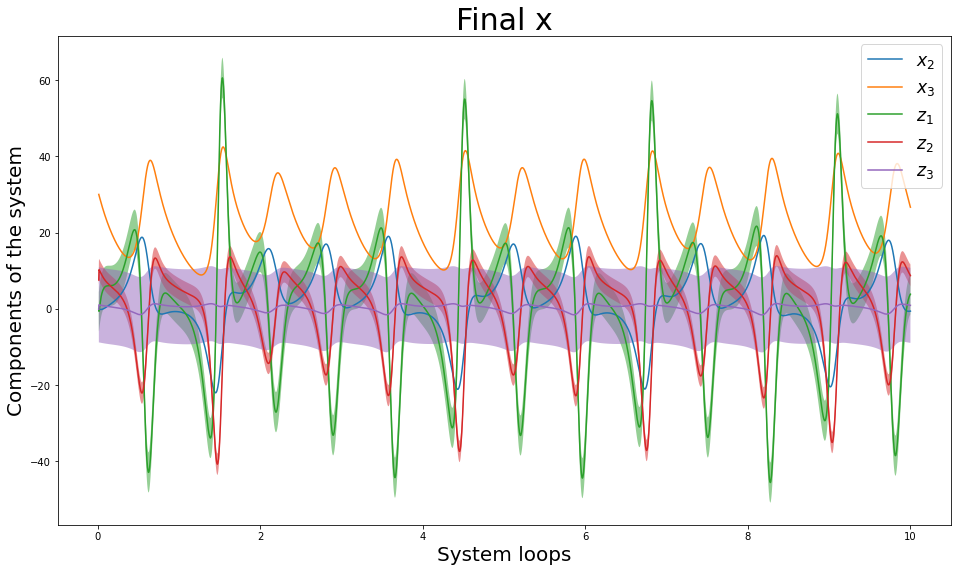

In [15]:
# plot the reconstructed components
for i in range(n):
    plot(t, x_s_V3[:,i], color=tab_colors[i])
    fill_between(t, x_s_V3[:,i]-1.96*sqrt(P_s_V3[:,i,i]), x_s_V3[:,i]+1.96*sqrt(P_s_V3[:,i,i]),
                 facecolor=tab_colors[i], alpha=0.50)

xlabel('System loops', size=20)
ylabel('Components of the system', size=20)
legend(tab_labels, loc=1, fontsize='xx-large')
title('Final x', size=30)

### Representation of the latent components

(0.01, 9.998999999999992)

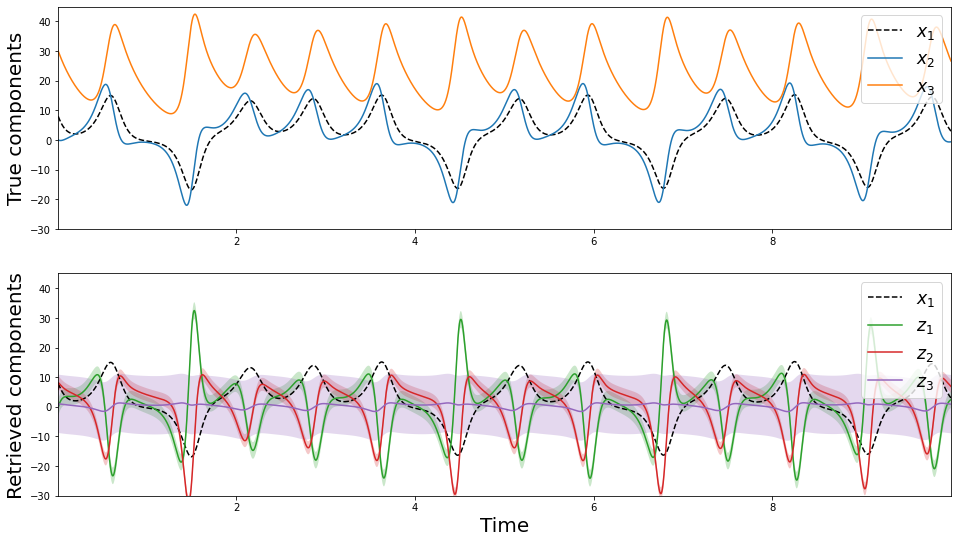

In [16]:
################
### FIGURE 2 ###
################

# true components
subplot(2,1,1)
tab_labels_fig1_a = ['$x_1$', '$x_2$', '$x_3$']
plot(t, x_t[:,i_unobs_comp], '--k')
plot(t, x_t[:,1], color='C0')
plot(t, x_t[:,2], color='C1')
ylabel('True components', size=20)
legend(tab_labels_fig1_a, loc=1, fontsize='xx-large')
ylim([-30,45])
xlim([t[0],t[-1]])

# retrieved components
subplot(2,1,2)
tab_labels_fig1_b = ['$x_1$', '$z_1$', '$z_2$', '$z_3$']
plot(t, x_t[:,i_unobs_comp], '--k')
plot(t, x_s_V1[:,2], color='C2')
plot(t, x_s_V2[:,3], color='C3')
plot(t, x_s_V3[:,4], color='C4')
fill_between(t, x_s_V1[:,2]-1.96*sqrt(P_s_V1[:,2,2]), x_s_V1[:,2]+1.96*sqrt(P_s_V1[:,2,2]),
                     facecolor='C2', alpha=0.25)
fill_between(t, x_s_V2[:,3]-1.96*sqrt(P_s_V2[:,3,3]), x_s_V2[:,3]+1.96*sqrt(P_s_V2[:,3,3]),
                     facecolor='C3', alpha=0.25)
fill_between(t, x_s_V3[:,4]-1.96*sqrt(P_s_V3[:,4,4]), x_s_V3[:,4]+1.96*sqrt(P_s_V3[:,4,4]),
                     facecolor='C4', alpha=0.25)
xlabel('Time', size=20)
ylabel('Retrieved components', size=20)
legend(tab_labels_fig1_b, loc=1, fontsize='xx-large')
ylim([-30,45])
xlim([t[0],t[-1]])

#savefig('/home/administrateur/Dropbox/Documents/Figures/Kalman/L63_true_hidden_components.png', bbox_inches='tight', dpi=400)

### Comparison of the different versions

In [5]:
nb_exp = 50
nb_iter_SEM = 30
tab_regress_coef_V1 = zeros((nb_exp, 2))
tab_loglik_V1       = zeros((nb_exp, nb_iter_SEM))
tab_regress_coef_V2 = zeros((nb_exp, 3))
tab_loglik_V2       = zeros((nb_exp, nb_iter_SEM))
tab_regress_coef_V3 = zeros((nb_exp, 4))
tab_loglik_V3       = zeros((nb_exp, nb_iter_SEM))

for i in range(nb_exp):
    
    print(i)
    
    random.seed(i)

    z_V1 = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])
    z_V2 = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])
    z_V3 = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])
    
    # state
    x = c_[y[:,0], y[:,1], z_V1]   
    
    # shapes
    n = shape(x)[1]
    p = shape(y)[1]
    
    # kalman parameters
    H = delete(eye(n), 2, axis=0)
    R = variance_obs_comp*eye(p)
    
    # stochastic EM
    x_s_V1, P_s_V1, M_V1, loglik_V1, x, x_f_V1, Q_V1 = Kalman_SEM(x, y, H, R, nb_iter_SEM)

    # regression coefficients
    regress_coef = linalg.lstsq(diff(x_s_V1[:,0:2], axis=0), x_s_V1[0:-1,2], rcond=None)[0]
    tab_regress_coef_V1[i,:] = regress_coef*dt
    tab_loglik_V1[i,:] = loglik_V1
    
    # state
    x = c_[x, z_V2]

    # shapes
    n = shape(x)[1]
    p = shape(y)[1]
    
    # kalman parameters
    H = delete(eye(n), [2,3], axis=0)
    R = variance_obs_comp*eye(p)

    # stochastic EM
    x_s_V2, P_s_V2, M_V2, loglik_V2, x, x_f_V2, Q_V2 = Kalman_SEM(x, y, H, R, nb_iter_SEM)
    
    # regression coefficients
    regress_coef = linalg.lstsq(diff(x_s_V2[:,0:3], axis=0), x_s_V2[0:-1,3], rcond=None)[0]
    tab_regress_coef_V2[i,:] = regress_coef*dt
    tab_loglik_V2[i,:] = loglik_V2
    
    # state
    x = c_[x, z_V3]

    # shapes
    n = shape(x)[1]
    p = shape(y)[1]
    
    # kalman parameters
    H = delete(eye(n), [2,3,4], axis=0)
    R = variance_obs_comp*eye(p)

    # stochastic EM
    x_s_V3, P_s_V3, M_V3, loglik_V3, x, x_f_V3, Q_V3 = Kalman_SEM(x, y, H, R, nb_iter_SEM)
    
    # regression coefficients
    regress_coef = linalg.lstsq(diff(x_s_V3[:,0:4], axis=0), x_s_V3[0:-1,4], rcond=None)[0]
    tab_regress_coef_V3[i,:] = regress_coef*dt
    tab_loglik_V3[i,:] = loglik_V3

0


100%|██████████| 30/30 [01:02<00:00,  2.07s/it]


1


100%|██████████| 30/30 [00:57<00:00,  1.93s/it]


2


100%|██████████| 30/30 [01:03<00:00,  2.12s/it]


3


100%|██████████| 30/30 [01:01<00:00,  2.04s/it]


4


100%|██████████| 30/30 [01:26<00:00,  2.90s/it]


5


100%|██████████| 30/30 [01:07<00:00,  2.26s/it]


6


100%|██████████| 30/30 [01:17<00:00,  2.59s/it]


7


100%|██████████| 30/30 [01:12<00:00,  2.40s/it]


8


100%|██████████| 30/30 [01:04<00:00,  2.16s/it]


9


100%|██████████| 30/30 [01:03<00:00,  2.13s/it]


10


100%|██████████| 30/30 [01:02<00:00,  2.07s/it]


11


100%|██████████| 30/30 [01:03<00:00,  2.11s/it]


12


100%|██████████| 30/30 [01:05<00:00,  2.18s/it]


13


100%|██████████| 30/30 [01:18<00:00,  2.60s/it]


14


100%|██████████| 30/30 [01:03<00:00,  2.11s/it]


15


100%|██████████| 30/30 [01:02<00:00,  2.09s/it]


16


100%|██████████| 30/30 [01:00<00:00,  2.03s/it]


17


100%|██████████| 30/30 [01:07<00:00,  2.24s/it]


18


100%|██████████| 30/30 [01:02<00:00,  2.09s/it]


19


100%|██████████| 30/30 [01:00<00:00,  2.03s/it]


20


100%|██████████| 30/30 [01:00<00:00,  2.03s/it]


21


100%|██████████| 30/30 [01:03<00:00,  2.11s/it]


22


100%|██████████| 30/30 [01:03<00:00,  2.11s/it]


23


100%|██████████| 30/30 [01:05<00:00,  2.19s/it]


24


100%|██████████| 30/30 [01:02<00:00,  2.08s/it]


25


100%|██████████| 30/30 [01:01<00:00,  2.07s/it]


26


100%|██████████| 30/30 [01:01<00:00,  2.06s/it]


27


100%|██████████| 30/30 [01:02<00:00,  2.07s/it]


28


100%|██████████| 30/30 [00:57<00:00,  1.92s/it]


29


100%|██████████| 30/30 [01:03<00:00,  2.12s/it]


30


100%|██████████| 30/30 [00:59<00:00,  1.98s/it]


31


100%|██████████| 30/30 [01:00<00:00,  2.03s/it]


32


100%|██████████| 30/30 [01:01<00:00,  2.05s/it]


33


100%|██████████| 30/30 [00:59<00:00,  2.00s/it]


34


100%|██████████| 30/30 [00:57<00:00,  1.93s/it]


35


100%|██████████| 30/30 [00:58<00:00,  1.95s/it]


36


100%|██████████| 30/30 [01:00<00:00,  2.01s/it]


37


100%|██████████| 30/30 [01:01<00:00,  2.06s/it]


38


100%|██████████| 30/30 [01:02<00:00,  2.07s/it]


39


100%|██████████| 30/30 [01:00<00:00,  2.00s/it]


40


100%|██████████| 30/30 [01:04<00:00,  2.14s/it]


41


100%|██████████| 30/30 [01:03<00:00,  2.11s/it]


42


100%|██████████| 30/30 [01:04<00:00,  2.16s/it]


43


100%|██████████| 30/30 [01:05<00:00,  2.19s/it]


44


100%|██████████| 30/30 [01:05<00:00,  2.20s/it]


45


100%|██████████| 30/30 [01:08<00:00,  2.28s/it]


46


100%|██████████| 30/30 [01:05<00:00,  2.18s/it]


47


100%|██████████| 30/30 [01:08<00:00,  2.29s/it]


48


100%|██████████| 30/30 [01:14<00:00,  2.47s/it]


49


100%|██████████| 30/30 [01:13<00:00,  2.45s/it]


In [28]:
# save experiments
#with open('save_lik_coef_V2.npy', 'wb') as f:
#    np.save(f, tab_regress_coef_V1)
#    np.save(f, tab_loglik_V1)
#    np.save(f, tab_regress_coef_V2)
#    np.save(f, tab_loglik_V2)
#    np.save(f, tab_regress_coef_V3)
#    np.save(f, tab_loglik_V3)
#    np.save(f, loglik_V0)
#    np.save(f, loglik_V1)
#    np.save(f, loglik_V2)
#    np.save(f, loglik_V3)

# load experiments
with open('save_lik_coef_V2.npy', 'rb') as f:
    tab_regress_coef_V1 = np.load(f)
    tab_loglik_V1 = np.load(f)
    tab_regress_coef_V2 = np.load(f)
    tab_loglik_V2 = np.load(f)
    tab_regress_coef_V3 = np.load(f)
    tab_loglik_V3 = np.load(f)
    loglik_V0 = np.load(f)
    loglik_V1 = np.load(f)
    loglik_V2 = np.load(f)
    loglik_V3 = np.load(f)

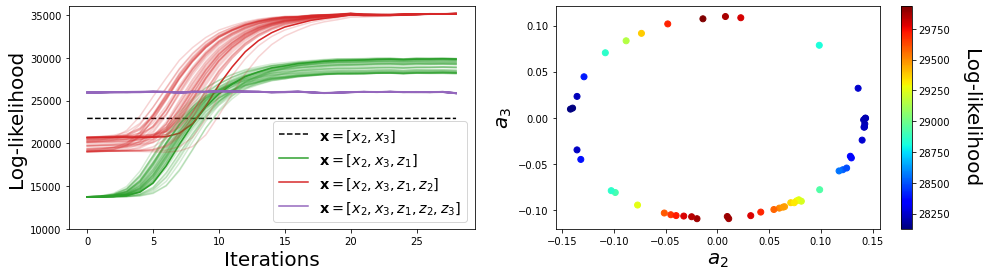

In [46]:
################
### FIGURE 3 ###
################

# plot the likelihood of the different models
subplot(2,2,1)
plot(loglik_V0[1:], '--k')
plot(loglik_V1[1:], color='C2')
plot(loglik_V2[1:], color='C3')
plot(loglik_V3[1:], color='C4')
ylim([10000, 36000])
xlabel('Iterations', size=20)
ylabel('Log-likelihood', size=20)
legend(['$\mathbf{x} = [x_2, x_3]$', '$\mathbf{x} = [x_2, x_3, z_1]$', '$\mathbf{x} = [x_2, x_3, z_1, z_2]$', '$\mathbf{x} = [x_2, x_3, z_1, z_2, z_3]$'],
       loc=0, fontsize='x-large')
plot(tab_loglik_V1[:,1:].T, color='C2', alpha=0.2)
plot(tab_loglik_V2[:,1:].T, color='C3', alpha=0.2)
plot(tab_loglik_V3[:,1:].T, color='C4', alpha=0.2)

# plot the a2 and a3 parameters 
subplot(2,2,2)
scatter(tab_regress_coef_V1[:,0], tab_regress_coef_V1[:,1], c=tab_loglik_V1[:,-1], cmap='jet')
cbar_V1 = colorbar()
cbar_V1.set_label('Log-likelihood', rotation=270, size=20, labelpad=30)
xlabel('$a_2$', size=20)
ylabel('$a_3$', size=20)

#savefig('/home/administrateur/Dropbox/Documents/Figures/Kalman/L63_compare_likelihoods.png', bbox_inches='tight', dpi=400)

### Examples of forecasts and metrics as a function of the lead time

In [16]:
random.seed(0)

z_V1 = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])
z_V2 = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])
z_V3 = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])

# state
x = c_[y[:,0], y[:,1], z_V1]

# shapes
n = shape(x)[1]
p = shape(y)[1]

# kalman parameters
H = delete(eye(n), 2, axis=0)
R = variance_obs_comp*eye(p)

# stochastic EM
x_s_V1, P_s_V1, M_V1, loglik_V1, x, x_f_V1, Q_V1 = Kalman_SEM(x, y, H, R, nb_iter_SEM)

# state
x = c_[x, z_V2]

# shapes
n = shape(x)[1]
p = shape(y)[1]

# kalman parameters
H = delete(eye(n), [2,3], axis=0)
R = variance_obs_comp*eye(p)

# stochastic EM
x_s_V2, P_s_V2, M_V2, loglik_V2, x, x_f_V2, Q_V2 = Kalman_SEM(x, y, H, R, nb_iter_SEM)

# state
x = c_[x, z_V3]

# shapes
n = shape(x)[1]
p = shape(y)[1]

# kalman parameters
H = delete(eye(n), [2,3,4], axis=0)
R = variance_obs_comp*eye(p)

# stochastic EM
x_s_V3, P_s_V3, M_V3, loglik_V3, x, x_f_V3, Q_V3 = Kalman_SEM(x, y, H, R, nb_iter_SEM)

100%|██████████| 30/30 [01:04<00:00,  2.15s/it]


In [17]:
def RMSE(x_for, x_true):
    return sqrt(mean((x_for-x_true)**2))
def cov_prob(x_for, P_for, x_true):
    sum = 0
    for k in range(len(x_for)):
        sum += (x_true[k] >= x_for[k] - 0.64 * sqrt(P_for[k])) and (x_true[k] <= x_for[k] + 0.64 * sqrt(P_for[k]))
    return sum/len(x_for)    

In [18]:
# test dataset
x_test = odeint(Lorenz_63, x_t[-1,:], arange(0.01, nb_loop, dt), args=(sigma, rho, beta))
y_test = x_test.copy()
y_test = delete(y_test, i_unobs_comp, axis=1)

# apply filter on the test dataset
H = eye(2)
x_for_V0, P_for_V0, tej1, tej2, x_s_V0, P_s_V0, tej5, tej6 = Kalman_smoother(y_test, x_s_V0[-1,:], P_s_V0[-1,:,:,], M_V0, Q_V0, H, R)
H = delete(eye(3), 2, axis=0)
x_for_V1, P_for_V1, tej1, tej2, x_s_V1, P_s_V1, tej5, tej6 = Kalman_smoother(y_test, x_s_V1[-1,:], P_s_V1[-1,:,:,], M_V1, Q_V1, H, R)
H = delete(eye(4), [2,3], axis=0)
x_for_V2, P_for_V2, tej1, tej2, x_s_V2, P_s_V2, tej5, tej6 = Kalman_smoother(y_test, x_s_V2[-1,:], P_s_V2[-1,:,:,], M_V2, Q_V2, H, R)
H = delete(eye(5), [2,3,4], axis=0)
x_for_V3, P_for_V3, tej1, tej2, x_s_V3, P_s_V3, tej5, tej6 = Kalman_smoother(y_test, x_s_V3[-1,:], P_s_V3[-1,:,:,], M_V3, Q_V3, H, R)

In [19]:
# max horizon
horizon = 500

# initialization
x_true   = zeros((len(x_test)-horizon, horizon, shape(x_test)[1]))
x_for_V0 = zeros((len(x_test)-horizon, horizon, shape(x_s_V0)[1]))
x_for_V1 = zeros((len(x_test)-horizon, horizon, shape(x_s_V1)[1]))
x_for_V2 = zeros((len(x_test)-horizon, horizon, shape(x_s_V2)[1]))
x_for_V3 = zeros((len(x_test)-horizon, horizon, shape(x_s_V3)[1]))
P_for_V0 = zeros((len(x_test)-horizon, horizon, shape(Q_V0)[0], shape(Q_V0)[1]))
P_for_V1 = zeros((len(x_test)-horizon, horizon, shape(Q_V1)[0], shape(Q_V1)[1]))
P_for_V2 = zeros((len(x_test)-horizon, horizon, shape(Q_V2)[0], shape(Q_V2)[1]))
P_for_V3 = zeros((len(x_test)-horizon, horizon, shape(Q_V3)[0], shape(Q_V3)[1]))

# loop on time steps
for k in range(len(x_t)-horizon):
    x_true[k,0,:] = x_test[k,:]
    x_for_V0[k,0,:] = x_s_V0[k,:]
    x_for_V1[k,0,:] = x_s_V1[k,:]
    x_for_V2[k,0,:] = x_s_V2[k,:]
    x_for_V3[k,0,:] = x_s_V3[k,:]
    P_for_V0[k,0,:,:] = P_s_V0[k,:,:]
    P_for_V1[k,0,:,:] = P_s_V1[k,:,:]
    P_for_V2[k,0,:,:] = P_s_V2[k,:,:]
    P_for_V3[k,0,:,:] = P_s_V3[k,:,:]
    # loop on horizons
    for h in range(horizon-1):
        x_true[k,h+1,:] = x_test[k+h+1,:]
        x_for_V0[k,h+1,:] = M_V0 @ x_for_V0[k,h,:]
        x_for_V1[k,h+1,:] = M_V1 @ x_for_V1[k,h,:]
        x_for_V2[k,h+1,:] = M_V2 @ x_for_V2[k,h,:]
        x_for_V3[k,h+1,:] = M_V3 @ x_for_V3[k,h,:]
        P_for_V0[k,h+1,:,:] = M_V0 @ P_for_V0[k,h,:,:] @ M_V0.T + Q_V0
        P_for_V1[k,h+1,:,:] = M_V1 @ P_for_V1[k,h,:,:] @ M_V1.T + Q_V1
        P_for_V2[k,h+1,:,:] = M_V2 @ P_for_V2[k,h,:,:] @ M_V2.T + Q_V2
        P_for_V3[k,h+1,:,:] = M_V3 @ P_for_V3[k,h,:,:] @ M_V3.T + Q_V3

In [20]:
# initialization
tab_RMSE_V0_x2 = zeros((horizon))
tab_RMSE_V1_x2 = zeros((horizon))
tab_RMSE_V2_x2 = zeros((horizon))
tab_RMSE_V3_x2 = zeros((horizon))
tab_RMSE_V0_x3 = zeros((horizon))
tab_RMSE_V1_x3 = zeros((horizon))
tab_RMSE_V2_x3 = zeros((horizon))
tab_RMSE_V3_x3 = zeros((horizon))

# loop on horizons
for h in range(horizon):
    tab_RMSE_V0_x2[h] = RMSE(x_for_V0[:,h,0], x_true[:,h,1])
    tab_RMSE_V1_x2[h] = RMSE(x_for_V1[:,h,0], x_true[:,h,1])
    tab_RMSE_V2_x2[h] = RMSE(x_for_V2[:,h,0], x_true[:,h,1])
    tab_RMSE_V3_x2[h] = RMSE(x_for_V3[:,h,0], x_true[:,h,1])
    tab_RMSE_V0_x3[h] = RMSE(x_for_V0[:,h,1], x_true[:,h,2])
    tab_RMSE_V1_x3[h] = RMSE(x_for_V1[:,h,1], x_true[:,h,2])
    tab_RMSE_V2_x3[h] = RMSE(x_for_V2[:,h,1], x_true[:,h,2])
    tab_RMSE_V3_x3[h] = RMSE(x_for_V3[:,h,1], x_true[:,h,2])

In [21]:
# initialization
tab_cov_prob_V0_x2 = zeros((horizon))
tab_cov_prob_V1_x2 = zeros((horizon))
tab_cov_prob_V2_x2 = zeros((horizon))
tab_cov_prob_V3_x2 = zeros((horizon))
tab_cov_prob_V0_x3 = zeros((horizon))
tab_cov_prob_V1_x3 = zeros((horizon))
tab_cov_prob_V2_x3 = zeros((horizon))
tab_cov_prob_V3_x3 = zeros((horizon))

# loop on horizons
for h in range(horizon):
    tab_cov_prob_V0_x2[h] = cov_prob(x_for_V0[:,h,0], P_for_V0[:,h,0,0], x_true[:,h,1])
    tab_cov_prob_V1_x2[h] = cov_prob(x_for_V1[:,h,0], P_for_V1[:,h,0,0], x_true[:,h,1])
    tab_cov_prob_V2_x2[h] = cov_prob(x_for_V2[:,h,0], P_for_V2[:,h,0,0], x_true[:,h,1])
    tab_cov_prob_V3_x2[h] = cov_prob(x_for_V3[:,h,0], P_for_V3[:,h,0,0], x_true[:,h,1])
    tab_cov_prob_V0_x3[h] = cov_prob(x_for_V0[:,h,1], P_for_V0[:,h,1,1], x_true[:,h,2])
    tab_cov_prob_V1_x3[h] = cov_prob(x_for_V1[:,h,1], P_for_V1[:,h,1,1], x_true[:,h,2])
    tab_cov_prob_V2_x3[h] = cov_prob(x_for_V2[:,h,1], P_for_V2[:,h,1,1], x_true[:,h,2])
    tab_cov_prob_V3_x3[h] = cov_prob(x_for_V3[:,h,1], P_for_V3[:,h,1,1], x_true[:,h,2])

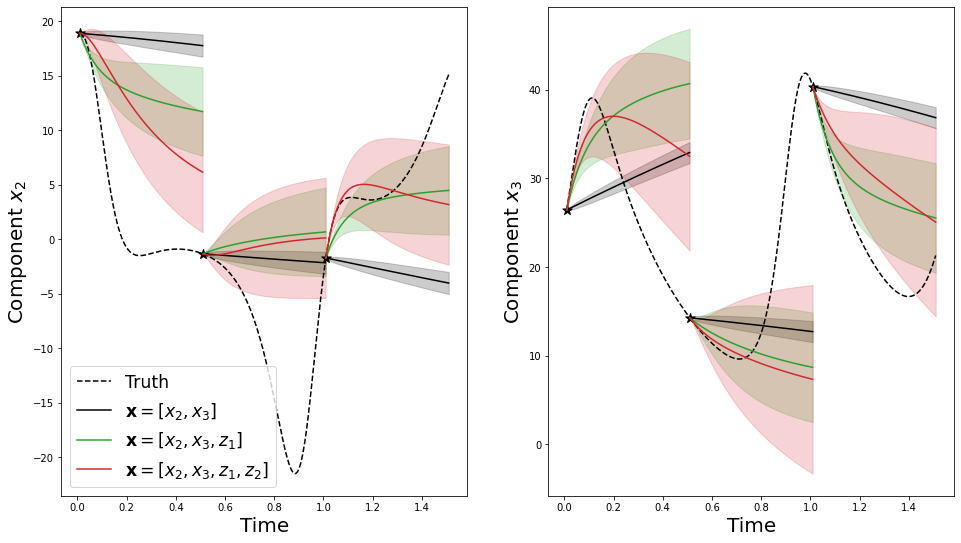

In [72]:
################
### FIGURE 4 ###
################

start_forecast = 8700 #4500 # 5100 # 6600
subplot(1,2,1)

plot(t[0:horizon], x_test[start_forecast-horizon:start_forecast,1], 'k--')
plot(t[0:horizon], x_for_V0[start_forecast-horizon,:,0], 'k')
plot(t[0:horizon], x_for_V1[start_forecast-horizon,:,0], 'C2')
plot(t[0:horizon], x_for_V2[start_forecast-horizon,:,0], 'C3')
fill_between(t[0:horizon], x_for_V0[start_forecast-horizon,:,0] - 0.64 * sqrt(P_for_V0[start_forecast-horizon,:,0,0]), x_for_V0[start_forecast-horizon,:,0] + 0.64 * sqrt(P_for_V0[start_forecast-horizon,:,0,0]), alpha=0.2, color='k')
fill_between(t[0:horizon], x_for_V1[start_forecast-horizon,:,0] - 0.64 * sqrt(P_for_V1[start_forecast-horizon,:,0,0]), x_for_V1[start_forecast-horizon,:,0] + 0.64 * sqrt(P_for_V1[start_forecast-horizon,:,0,0]), alpha=0.2, color='C2')
fill_between(t[0:horizon], x_for_V2[start_forecast-horizon,:,0] - 0.64 * sqrt(P_for_V2[start_forecast-horizon,:,0,0]), x_for_V2[start_forecast-horizon,:,0] + 0.64 * sqrt(P_for_V2[start_forecast-horizon,:,0,0]), alpha=0.2, color='C3')

plot(t[horizon:2*horizon], x_true[start_forecast,:,1], 'k--')
plot(t[horizon:2*horizon], x_for_V0[start_forecast,:,0], 'k')
plot(t[horizon:2*horizon], x_for_V1[start_forecast,:,0], 'C2')
plot(t[horizon:2*horizon], x_for_V2[start_forecast,:,0], 'C3')
fill_between(t[horizon:2*horizon], x_for_V0[start_forecast,:,0] - 0.64 * sqrt(P_for_V0[start_forecast,:,0,0]), x_for_V0[start_forecast,:,0] + 0.64 * sqrt(P_for_V0[start_forecast,:,0,0]), alpha=0.2, color='k')
fill_between(t[horizon:2*horizon], x_for_V1[start_forecast,:,0] - 0.64 * sqrt(P_for_V1[start_forecast,:,0,0]), x_for_V1[start_forecast,:,0] + 0.64 * sqrt(P_for_V1[start_forecast,:,0,0]), alpha=0.2, color='C2')
fill_between(t[horizon:2*horizon], x_for_V2[start_forecast,:,0] - 0.64 * sqrt(P_for_V2[start_forecast,:,0,0]), x_for_V2[start_forecast,:,0] + 0.64 * sqrt(P_for_V2[start_forecast,:,0,0]), alpha=0.2, color='C3')

plot(t[2*horizon:3*horizon], x_true[start_forecast+horizon,:,1], 'k--')
plot(t[2*horizon:3*horizon], x_for_V0[start_forecast+horizon,:,0], 'k')
plot(t[2*horizon:3*horizon], x_for_V1[start_forecast+horizon,:,0], 'C2')
plot(t[2*horizon:3*horizon], x_for_V2[start_forecast+horizon,:,0], 'C3')
fill_between(t[2*horizon:3*horizon], x_for_V0[start_forecast+horizon,:,0] - 0.64 * sqrt(P_for_V0[start_forecast+horizon,:,0,0]), x_for_V0[start_forecast+horizon,:,0] + 0.64 * sqrt(P_for_V0[start_forecast+horizon,:,0,0]), alpha=0.2, color='k')
fill_between(t[2*horizon:3*horizon], x_for_V1[start_forecast+horizon,:,0] - 0.64 * sqrt(P_for_V1[start_forecast+horizon,:,0,0]), x_for_V1[start_forecast+horizon,:,0] + 0.64 * sqrt(P_for_V1[start_forecast+horizon,:,0,0]), alpha=0.2, color='C2')
fill_between(t[2*horizon:3*horizon], x_for_V2[start_forecast+horizon,:,0] - 0.64 * sqrt(P_for_V2[start_forecast+horizon,:,0,0]), x_for_V2[start_forecast+horizon,:,0] + 0.64 * sqrt(P_for_V2[start_forecast+horizon,:,0,0]), alpha=0.2, color='C3')

ylabel('Component $x_2$', size=20)
xlabel('Time', size=20)

scatter(t[0], x_true[start_forecast-horizon,0,1], marker='*', color='k', s=100)
scatter(t[horizon], x_true[start_forecast,0,1], marker='*', color='k', s=100)
scatter(t[2*horizon], x_true[start_forecast+horizon,0,1], marker='*', color='k', s=100)

legend(['Truth', '$\mathbf{x} = [x_2, x_3]$', '$\mathbf{x} = [x_2, x_3, z_1]$', '$\mathbf{x} = [x_2, x_3, z_1, z_2]$'],
       loc=0, fontsize='xx-large')

'''
plot([t[0], t[0]], [-20, 20], color='k')
plot([t[horizon], t[horizon]], [-20, 20], color='k')
plot([t[2*horizon], t[2*horizon]], [-20, 20], color='k')
plot([t[3*horizon], t[3*horizon]], [-20, 20], color='k')
'''

subplot(1,2,2)

plot(t[0:horizon], x_test[start_forecast-horizon:start_forecast,2], 'k--')
plot(t[0:horizon], x_for_V0[start_forecast-horizon,:,1], 'k')
plot(t[0:horizon], x_for_V1[start_forecast-horizon,:,1], 'C2')
plot(t[0:horizon], x_for_V2[start_forecast-horizon,:,1], 'C3')
fill_between(t[0:horizon], x_for_V0[start_forecast-horizon,:,1] - 0.64 * sqrt(P_for_V0[start_forecast-horizon,:,1,1]), x_for_V0[start_forecast-horizon,:,1] + 0.64 * sqrt(P_for_V0[start_forecast-horizon,:,1,1]), alpha=0.2, color='k')
fill_between(t[0:horizon], x_for_V1[start_forecast-horizon,:,1] - 0.64 * sqrt(P_for_V1[start_forecast-horizon,:,1,1]), x_for_V1[start_forecast-horizon,:,1] + 0.64 * sqrt(P_for_V1[start_forecast-horizon,:,1,1]), alpha=0.2, color='C2')
fill_between(t[0:horizon], x_for_V2[start_forecast-horizon,:,1] - 0.64 * sqrt(P_for_V2[start_forecast-horizon,:,1,1]), x_for_V2[start_forecast-horizon,:,1] + 0.64 * sqrt(P_for_V2[start_forecast-horizon,:,1,1]), alpha=0.2, color='C3')

plot(t[horizon:2*horizon], x_true[start_forecast,:,2], 'k--')
plot(t[horizon:2*horizon], x_for_V0[start_forecast,:,1], 'k')
plot(t[horizon:2*horizon], x_for_V1[start_forecast,:,1], 'C2')
plot(t[horizon:2*horizon], x_for_V2[start_forecast,:,1], 'C3')
fill_between(t[horizon:2*horizon], x_for_V0[start_forecast,:,1] - 0.64 * sqrt(P_for_V0[start_forecast,:,1,1]), x_for_V0[start_forecast,:,1] + 0.64 * sqrt(P_for_V0[start_forecast,:,1,1]), alpha=0.2, color='k')
fill_between(t[horizon:2*horizon], x_for_V1[start_forecast,:,1] - 0.64 * sqrt(P_for_V1[start_forecast,:,1,1]), x_for_V1[start_forecast,:,1] + 0.64 * sqrt(P_for_V1[start_forecast,:,1,1]), alpha=0.2, color='C2')
fill_between(t[horizon:2*horizon], x_for_V2[start_forecast,:,1] - 0.64 * sqrt(P_for_V2[start_forecast,:,1,1]), x_for_V2[start_forecast,:,1] + 0.64 * sqrt(P_for_V2[start_forecast,:,1,1]), alpha=0.2, color='C3')

plot(t[2*horizon:3*horizon], x_true[start_forecast+horizon,:,2], 'k--')
plot(t[2*horizon:3*horizon], x_for_V0[start_forecast+horizon,:,1], 'k')
plot(t[2*horizon:3*horizon], x_for_V1[start_forecast+horizon,:,1], 'C2')
plot(t[2*horizon:3*horizon], x_for_V2[start_forecast+horizon,:,1], 'C3')
fill_between(t[2*horizon:3*horizon], x_for_V0[start_forecast+horizon,:,1] - 0.64 * sqrt(P_for_V0[start_forecast+horizon,:,1,1]), x_for_V0[start_forecast+horizon,:,1] + 0.64 * sqrt(P_for_V0[start_forecast+horizon,:,1,1]), alpha=0.2, color='k')
fill_between(t[2*horizon:3*horizon], x_for_V1[start_forecast+horizon,:,1] - 0.64 * sqrt(P_for_V1[start_forecast+horizon,:,1,1]), x_for_V1[start_forecast+horizon,:,1] + 0.64 * sqrt(P_for_V1[start_forecast+horizon,:,1,1]), alpha=0.2, color='C2')
fill_between(t[2*horizon:3*horizon], x_for_V2[start_forecast+horizon,:,1] - 0.64 * sqrt(P_for_V2[start_forecast+horizon,:,1,1]), x_for_V2[start_forecast+horizon,:,1] + 0.64 * sqrt(P_for_V2[start_forecast+horizon,:,1,1]), alpha=0.2, color='C3')

ylabel('Component $x_3$', size=20)
xlabel('Time', size=20)

scatter(t[0], x_true[start_forecast-horizon,0,2], marker='*', color='k', s=100)
scatter(t[horizon], x_true[start_forecast,0,2], marker='*', color='k', s=100)
scatter(t[2*horizon], x_true[start_forecast+horizon,0,2], marker='*', color='k', s=100)

#suptitle('Statistical forecasts using linear operators', size=30)

savefig('/home/administrateur/Dropbox/Documents/Figures/Kalman/L63_example_3_forecasts.png', bbox_inches='tight', dpi=400)

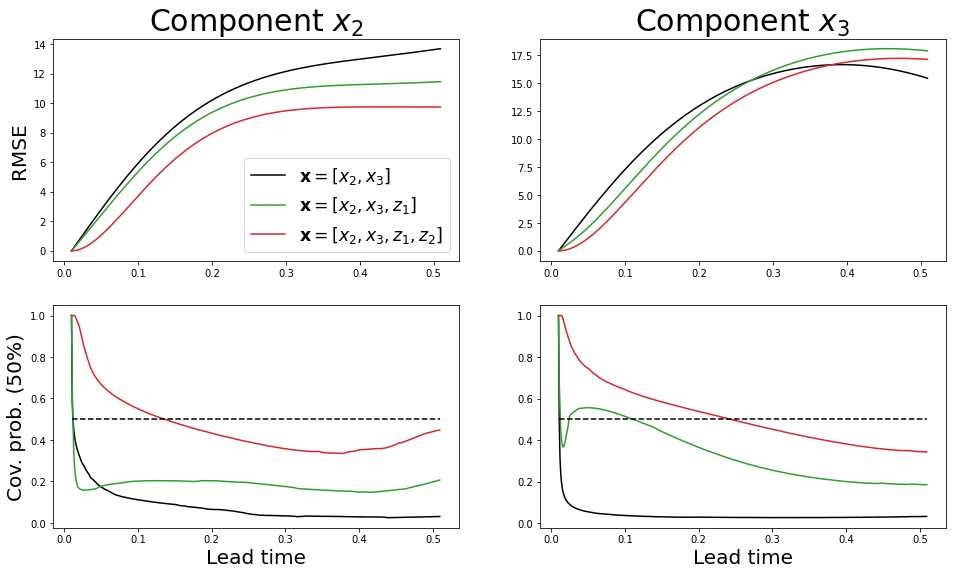

In [71]:
################
### FIGURE 5 ###
################

# plot RMSE ~ horizon for x2
subplot(2,2,1)
plot(t[0:horizon], tab_RMSE_V0_x2, 'k')
plot(t[0:horizon], tab_RMSE_V1_x2, 'C2')
plot(t[0:horizon], tab_RMSE_V2_x2, 'C3')
#xlabel('Horizon', size=20)
ylabel('RMSE', size=20)
title('Component $x_2$', size=30)
legend(['$\mathbf{x} = [x_2, x_3]$', '$\mathbf{x} = [x_2, x_3, z_1]$', '$\mathbf{x} = [x_2, x_3, z_1, z_2]$'],
       loc=0, fontsize='xx-large')

# plot RMSE ~ horizon for x3
subplot(2,2,2)
plot(t[0:horizon], tab_RMSE_V0_x3, 'k')
plot(t[0:horizon], tab_RMSE_V1_x3, 'C2')
plot(t[0:horizon], tab_RMSE_V2_x3, 'C3')
#xlabel('Horizon', size=20)
#ylabel('RMSE', size=20)
title('Component $x_3$', size=30)

# plot cov_prob ~ horizon for x2
subplot(2,2,3)
plot(t[0:horizon], tab_cov_prob_V0_x2, 'k')
plot(t[0:horizon], tab_cov_prob_V1_x2, 'C2')
plot(t[0:horizon], tab_cov_prob_V2_x2, 'C3')
plot([t[0], t[horizon]], [0.5, 0.5], 'k--')
xlabel('Lead time', size=20)
ylabel('Cov. prob. (50%)', size=20)

# plot cov_prob ~ horizon for x3
subplot(2,2,4)
plot(t[0:horizon], tab_cov_prob_V0_x3, 'k')
plot(t[0:horizon], tab_cov_prob_V1_x3, 'C2')
plot(t[0:horizon], tab_cov_prob_V2_x3, 'C3')
plot([t[0], t[horizon]], [0.5, 0.5], 'k--')
xlabel('Lead time', size=20)
#ylabel('Cov. prob. (50%)', size=20)

#savefig('/home/administrateur/Dropbox/Documents/Figures/Kalman/L63_RMSE_cov_prob.png', bbox_inches='tight', dpi=400)

In [31]:
print(tab_RMSE_V0_x2[50])
print(tab_RMSE_V1_x2[50])
print(tab_RMSE_V2_x2[50])
print(tab_RMSE_V2_x3[50])

3.455229235640996
3.0353736118007997
1.5347326913856825
1.6635938494907323


Relative improvement at: 0.1


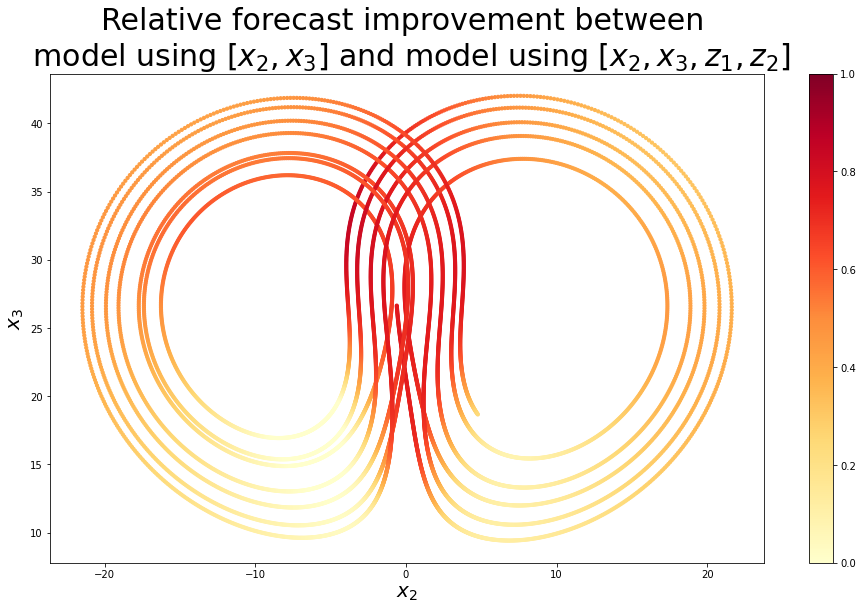

In [25]:
################
### FIGURE 6 ###
################

dt_forecast = 100
print('Relative improvement at: ' + str(dt*dt_forecast))

# distance between forecast and truth
dist_V0 = sqrt((x_for_V0[:,dt_forecast,0] - x_true[:,dt_forecast,1])**2 + (x_for_V0[:,dt_forecast,1] - x_true[:,dt_forecast,2])**2)
dist_V1 = sqrt((x_for_V1[:,dt_forecast,0] - x_true[:,dt_forecast,1])**2 + (x_for_V1[:,dt_forecast,1] - x_true[:,dt_forecast,2])**2)
dist_V2 = sqrt((x_for_V2[:,dt_forecast,0] - x_true[:,dt_forecast,1])**2 + (x_for_V2[:,dt_forecast,1] - x_true[:,dt_forecast,2])**2)

# plot the relative improvement between [x2, x3] and [x2, x3, z1, z2]
scatter(x_true[:,0,1], x_true[:,0,2], s=10, c = 1 - dist_V2 / dist_V0, cmap='YlOrRd')
xlabel('$x_2$', size=20)
ylabel('$x_3$', size=20)
clim([0, 1])
cbar = plt.colorbar()
#cbar.set_label('$1 - \\frac{\mathrm{dist}(\mathbf{M}[x_2, x_3, z_1, z_2])}{\mathrm{dist}(\mathbf{M}[x_2, x_3])}$', rotation=270, size=20, labelpad=50)
title('Relative forecast improvement between \n model using $[x_2, x_3]$ and model using $[x_2, x_3, z_1, z_2]$', size=30)

savefig('/home/administrateur/Dropbox/Documents/Figures/Kalman/L63_relative_improvement.png', bbox_inches='tight', dpi=400)